# Feature Engineering

In [139]:
import os
import json

import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

### Define Weight of Evidence function

Transform discrete variable to a continuous one by

$$
WOE_{varlabel} = \log\left(\frac{\text{% of events}}{\text{% of non-events}}\right)
$$

In [131]:
def get_woe(DF, var):
    events = DF.groupby(var)["return"].sum()
    non_events = DF.groupby(var)["return"].count() - events

    events.loc[events == 0] = 0.5
    non_events.loc[non_events == 0] = 0.5

    total_events = DF["return"].sum()
    total_non_events = len(DF) - total_events

    woe = np.log((events/total_events) / (non_events/total_non_events))
    woe.name = var + "_woe"
    return woe


In [91]:
with open(os.path.join("..", "data", "colorconverter.json")) as f:
    colors = json.load(f)

### Load data

In [92]:
dtypes = {"item_id": object, "brand_id": object, "user_id": object}

datapath = os.path.join("..", "data", "BADS_WS1819_known.csv")
data = pd.read_csv(datapath, dtype=dtypes, index_col=["order_item_id"],
                   converters={"item_color": lambda x: colors.get(x, "other")},
                   na_values=["not_reported"],
                   parse_dates=["order_date", "delivery_date", "user_dob",
                                "user_reg_date"])

## User specific features

In [93]:
# Days until item is delivered
data["days_to_delivery"] = (data.delivery_date - data.order_date).dt.days
data["num_previous_orders"] = data.groupby("user_id").order_date.cumcount()

In [94]:
# User tenure: days since registration
tenure = (data.order_date - data.user_reg_date).dt.days
data["user_tenure"] = np.maximum(tenure, 1)

In [95]:
# Number of previous orders
previous_orders = data.groupby("user_id").order_date.rank(method="dense") - 1
data["num_previous_orders"] = previous_orders

In [96]:
# Average number of previous orders (per 30 days, proxy for month)
orders_per_day = data.num_previous_orders / data.user_tenure
data["avg_num_orders"] = 30 * orders_per_day

In [97]:
# Average amount per order (in EUR)
aggdict = {"item_price": "sum", "item_id": "count"}
orders = data.groupby(["user_id", "order_date"]).agg(aggdict)

avg_amount_per_order = orders.item_price / orders.item_id
orders["avg_amount_order"] = avg_amount_per_order

# Cumulated sum price - this needs to be normalized
orders["cum_amount"] = orders.item_price.cumsum()

data = data.reset_index().set_index(["user_id", "order_date"])
data = data.join(orders, how="left", rsuffix="_order")

# Average number of orders
users = orders.groupby("user_id").agg({"item_id": "cumsum"})
data = data.join(users, how="left", rsuffix="_user")

data = data.reset_index().set_index("order_item_id")
data["return_indicator"] = data.cum_amount / (data.num_previous_orders + 1)
data["avg_order_size"] = data.item_id_user / (data.num_previous_orders + 1)

In [98]:
data.columns

Index(['user_id', 'order_date', 'delivery_date', 'item_id', 'item_size',
       'item_color', 'brand_id', 'item_price', 'user_title', 'user_dob',
       'user_state', 'user_reg_date', 'return', 'days_to_delivery',
       'num_previous_orders', 'user_tenure', 'avg_num_orders',
       'item_price_order', 'item_id_order', 'avg_amount_order', 'cum_amount',
       'item_id_user', 'return_indicator', 'avg_order_size'],
      dtype='object')

In [99]:
data.head()

,user_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_title,user_dob,...,num_previous_orders,user_tenure,avg_num_orders,item_price_order,item_id_order,avg_amount_order,cum_amount,item_id_user,return_indicator,avg_order_size
order_item_id,,,,,,,,,,,,,,,,,,,,,
ID34476,1000,2016-04-02,NaT,558,41,whiteish,150,79.95,Mrs,NaT,...,0.0,13,0.000000,79.95,1,79.95,79.95,1,79.950,1.0
ID26304,1000,2016-09-26,2016-09-27,3232,s,redish,111,99.90,Mrs,NaT,...,1.0,190,0.157895,126.80,2,63.40,206.75,3,103.375,1.5
ID64198,1000,2016-09-26,NaT,3066,s,blueish,137,26.90,Mrs,NaT,...,1.0,190,0.157895,126.80,2,63.40,206.75,3,103.375,1.5
ID55962,10001,2016-04-17,2016-05-11,1820,33,redish,115,34.95,Mrs,1984-05-31,...,0.0,1,0.000000,34.95,1,34.95,241.70,1,241.700,1.0
ID15082,10005,2016-04-17,2016-06-15,548,xl,whiteish,120,119.90,Mrs,1958-03-05,...,0.0,425,0.000000,189.80,2,94.90,431.50,2,431.500,2.0


## Data-driven feature engineering
### Transform continouus variable to discrete

Try and use a decision tree and to extract the leaf-assignment of each sample:
```python
clf = DecisionTreeClassifier(max_depth=5).fit(X, y)
clf.apply(data)
```

But maybe not in the goddamn train

In [102]:
# Create Age-Variable and discretize it
data["age"] = (data.order_date - data.user_dob).dt.days // 365
discretize_age_tree = DecisionTreeClassifier(max_depth=5)
age_values = data.loc[~pd.isna(data.age), ["age", "return"]]
discretize_age_tree.fit(age_values.age.values.reshape((-1, 1)),
                        age_values["return"].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Transform discrete variable to continuous

Transform by Weight of Evidence approach

In [132]:
item_size_woe = get_woe(data, "item_size")
brand_id_woe = get_woe(data, "brand_id")
item_id_woe = get_woe(data, "item_id")

In [134]:
data = data.join(item_size_woe, on="item_size")
data = data.join(brand_id_woe, on="brand_id")
data = data.join(item_id_woe, on="item_id")

In [135]:
data.head()

,user_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_title,user_dob,...,item_id_order,avg_amount_order,cum_amount,item_id_user,return_indicator,avg_order_size,age,item_size_woe,brand_id_woe,item_id_woe
order_item_id,,,,,,,,,,,,,,,,,,,,,
ID34476,1000,2016-04-02,NaT,558,41,whiteish,150,79.95,Mrs,NaT,...,1,79.95,79.95,1,79.950,1.0,NaN,0.315559,0.040283,-0.245381
ID26304,1000,2016-09-26,2016-09-27,3232,s,redish,111,99.90,Mrs,NaT,...,2,63.40,206.75,3,103.375,1.5,NaN,-0.073568,0.317392,0.549155
ID64198,1000,2016-09-26,NaT,3066,s,blueish,137,26.90,Mrs,NaT,...,2,63.40,206.75,3,103.375,1.5,NaN,-0.073568,-0.154501,-0.656007
ID55962,10001,2016-04-17,2016-05-11,1820,33,redish,115,34.95,Mrs,1984-05-31,...,1,34.95,241.70,1,241.700,1.0,31.0,-0.193556,-0.605476,0.766220
ID15082,10005,2016-04-17,2016-06-15,548,xl,whiteish,120,119.90,Mrs,1958-03-05,...,2,94.90,431.50,2,431.500,2.0,58.0,-0.018362,0.477725,0.692112


## Define seasonal dummies

* Christmas season: 1 week before christmas? Maybe look at mean number of orders?
* Valentines day season: same
* Black-Friday to Cyber Monday: at least this shit is well defined...

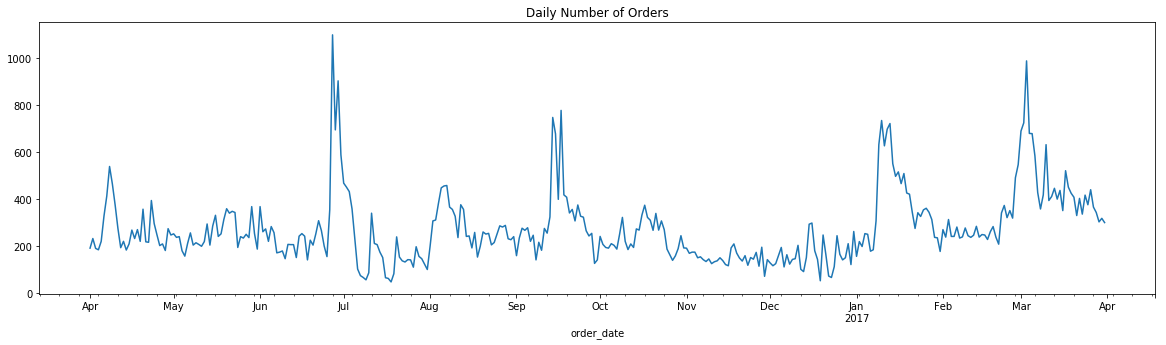

In [143]:
data.reset_index().groupby("order_date").order_item_id.count().plot(
    figsize=(20, 5),
    title="Daily Number of Orders")
plt.show()

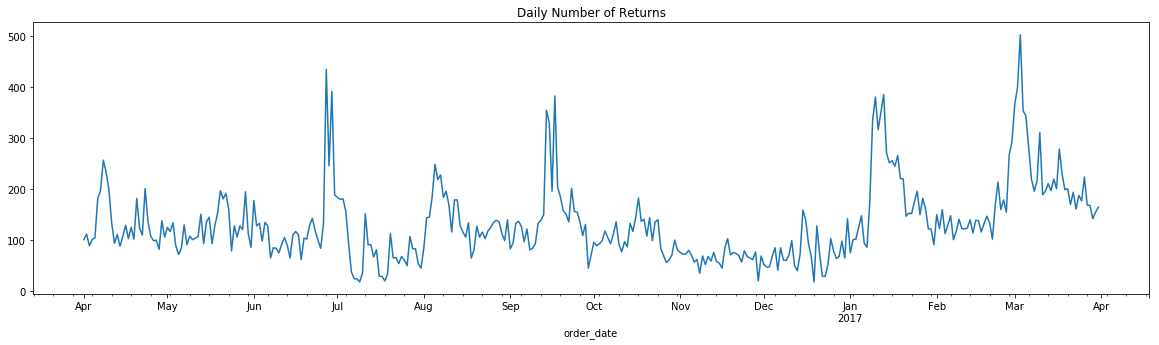

In [144]:
data.reset_index().groupby("order_date")["return"].sum().plot(
    figsize=(20, 5),
    title="Daily Number of Returns")
plt.show()